# Hands-on Activity 7.1 Deep Learning in Time Series

Technological Institute of the Philippines | Quezon City - Computer Engineering
--- | ---
Course Code: | CPE 313
Code Title: | Advanced Machine Learning and Deep Learning
2nd Semester | AY 2023-2024
--- | ---
<u>**ACTIVITY NO. 7.1** | **Deep Learning in Time Series**
**Name** | Mendoza, Paulo
--- | ---
**Section** | CPE32S8
**Date Performed**: | May 10, 2024
**Date Submitted**: | May 10, 2024
**Instructor**: | Engr. Roman M. Richard

### Objective(s):

This activity aims to introduce how to build and train a simple RNN or LSTM for time series
forecasting, using Keras.

### Intended Learning Outcomes (ILOs):

Demonstrate how to build and train RNN for time series forecasting

*   Demonstrate how to build and train RNN for time series forecasting
*   Demonstrate how to build and train LSTM for time series forecasting

### Resources:

*   Jupyter Notebook
*   Beijing.csv

# Procedures

Load the necessary libraries

In [1]:
%matplotlib inline
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM

Build a recurrent neural network and train it to forecast a single time series.
Load and setup the dataset

In [2]:
df_Beijing = pd.read_csv('/content/drive/MyDrive/data sci 3 files/mounted files/Beijing.csv')
df_Beijing = df_Beijing[df_Beijing.year >= 2015]
df_Beijing.head(10)

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
43824,43825,2015,1,1,0,4,5.0,32.0,8.0,22.0,-21.0,29.0,1034.0,-6.0,SE,0.89,0.0,0.0
43825,43826,2015,1,1,1,4,4.0,12.0,7.0,9.0,-22.0,23.0,1034.0,-4.0,NW,4.92,0.0,0.0
43826,43827,2015,1,1,2,4,3.0,19.0,7.0,9.0,-21.0,27.0,1034.0,-5.0,NW,8.94,0.0,0.0
43827,43828,2015,1,1,3,4,4.0,9.0,11.0,13.0,-21.0,29.0,1035.0,-6.0,NW,12.96,0.0,0.0
43828,43829,2015,1,1,4,4,3.0,11.0,5.0,10.0,-21.0,27.0,1034.0,-5.0,NW,16.98,0.0,0.0
43829,43830,2015,1,1,5,4,3.0,18.0,3.0,6.0,-22.0,23.0,1034.0,-4.0,NW,24.13,0.0,0.0
43830,43831,2015,1,1,6,4,3.0,20.0,6.0,8.0,-23.0,22.0,1034.0,-5.0,NW,25.92,0.0,0.0
43831,43832,2015,1,1,7,4,3.0,22.0,7.0,17.0,-22.0,26.0,1035.0,-6.0,SE,1.79,0.0,0.0
43832,43833,2015,1,1,8,4,NaN,NaN,NaN,11.0,-22.0,29.0,1035.0,-7.0,cv,0.89,0.0,0.0
43833,43834,2015,1,1,9,4,5.0,37.0,11.0,33.0,-22.0,24.0,1035.0,-5.0,NE,1.79,0.0,0.0


Forecast the 'PM' series, which are measurements of air pollution for several different districts. Note
that there are occasional missing values in these series, which we can fill with simple linear
interpolation. To start, we'll focus on the "PM_Dongsi" series and interpolate the missing values.

In [3]:
df_Beijing['PM_Dongsi'] = df_Beijing['PM_Dongsi'].interpolate()
df_Beijing['PM_Dongsi'].head(10)

43824    5.0
43825    4.0
43826    3.0
43827    4.0
43828    3.0
43829    3.0
43830    3.0
43831    3.0
43832    4.0
43833    5.0
Name: PM_Dongsi, dtype: float64

Create a function to extract and plot the last n days of data

In [4]:
def get_n_last_days(df, series_name, n_days):
  """
  Extract last n_days of an hourly time series
  """
  return df[series_name][-(24*n_days):]
def plot_n_last_days(df, series_name, n_days):
  """
  Plot last n_days of an hourly time series
  """
  plt.plot(get_n_last_days(df, series_name, n_days), 'k-')
  plt.title('{0} Air Quality Time Series - {1} days'
  .format(series_name, n_days))
  plt.xlabel('Recorded Hour')
  plt.ylabel('Reading')
  plt.grid(alpha=0.3)

Check last 6 weeks of data look like

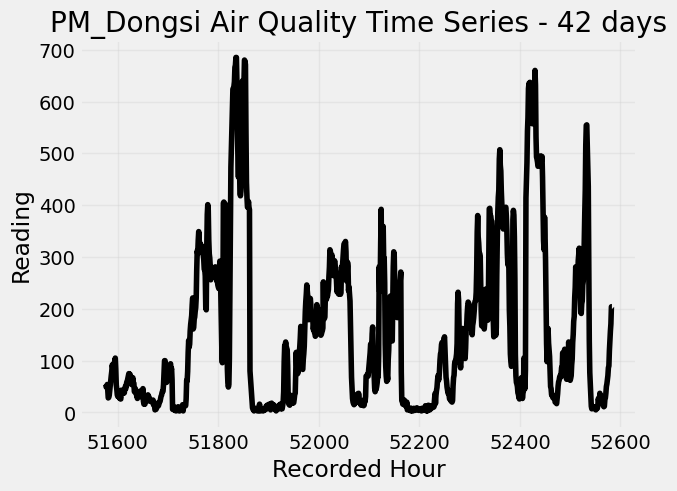

In [5]:
plot_n_last_days(df_Beijing, 'PM_Dongsi', 42)

Train a simple RNN to forecast the PM_Dongsi time series

In [6]:
def get_keras_format_series(series):
    """
    Convert a series to a numpy array of shape
    [n_samples, time_steps, features]
    """

    series = np.array(series)
    return series.reshape(series.shape[0], series.shape[1], 1)

def get_train_test_data(df, series_name, series_days, input_hours,
                        test_hours, sample_gap=3):
    """
    Utility processing function that splits an hourly time series into
    train and test with keras-friendly format, according to user-specified
    choice of shape.

    arguments
    ---------
    df (dataframe): dataframe with time series columns
    series_name (string): column name in df
    series_days (int): total days to extract
    input_hours (int): length of sequence input to network
    test_hours (int): length of held-out terminal sequence
    sample_gap (int): step size between start of train sequences; default 5

    returns
    ---------
    tuple: train_X, test_X_init, train_y, test_y
    """

    forecast_series = get_n_last_days(df, series_name, series_days).values # reducing our forecast series to last n days

    train = forecast_series[:-test_hours] # training data is remaining days until amount of test_hours
    test = forecast_series[-test_hours:] # test data is the remaining test_hours

    train_X, train_y = [], []

    # range 0 through # of train samples - input_hours by sample_gap.
    # This is to create many samples with corresponding
    for i in range(0, train.shape[0]-input_hours, sample_gap):
        train_X.append(train[i:i+input_hours]) # each training sample is of length input hours
        train_y.append(train[i+input_hours]) # each y is just the next step after training sample

    train_X = get_keras_format_series(train_X) # format our new training set to keras format
    train_y = np.array(train_y) # make sure y is an array to work properly with keras

    # The set that we had held out for testing (must be same length as original train input)
    test_X_init = test[:input_hours]
    test_y = test[input_hours:] # test_y is remaining values from test set

    return train_X, test_X_init, train_y, test_y

With the get_train_test_data utility function in hand, we're all set to extract keras-friendly arrays and
start training simple RNN models. We run this function in the cell below. We use the last 56 days of
the PM_Dongsi series, and will train a model that takes in 12 time steps in order to predict the next
time step. We use the last day of data for visually testing the model.

In [7]:
series_days = 56
input_hours = 12
test_hours = 24

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df_Beijing, 'PM_Dongsi', series_days,
                         input_hours, test_hours))

Below we see that by taking multiple time slices, we get 436 training samples of 12 time steps each.

In [8]:
print('Training input shape: {}'.format(train_X.shape))
print('Training output shape: {}'.format(train_y.shape))
print('Test input shape: {}'.format(test_X_init.shape))
print('Test output shape: {}'.format(test_y.shape))

Training input shape: (436, 12, 1)
Training output shape: (436,)
Test input shape: (12,)
Test output shape: (12,)


Train a simple RNN model using keras.

In [9]:
def fit_SimpleRNN(train_X, train_y, cell_units, epochs):
    """
    Fit Simple RNN to data train_X, train_y

    arguments
    ---------
    train_X (array): input sequence samples for training
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for RNN cells
    epochs (int): number of training epochs
    """

    # initialize model
    model = Sequential()

    # construct an RNN layer with specified number of hidden units
    # per cell and desired sequence input format
    model.add(SimpleRNN(cell_units, input_shape=(train_X.shape[1],1)))

    # add an output layer to make final predictions
    model.add(Dense(1))

    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs)
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=0)

    return model

Use this function to fit a very simple baseline model.

In [10]:
model = fit_SimpleRNN(train_X, train_y, cell_units=10, epochs=10)

This prediction method and a utility function for plotting its output against the ground truth are
defined below.

In [11]:
def predict(X_init, n_steps, model):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series
    """

    X_init = X_init.copy().reshape(1,-1,1)
    preds = []

    # iteratively take current input sequence, generate next step pred,
    # and shift input sequence forward by a step (to end with latest pred).
    # collect preds as we go.
    for _ in range(n_steps):
        pred = model.predict(X_init)
        preds.append(pred)
        X_init[:,:-1,:] = X_init[:,1:,:] # replace first 11 values with 2nd through 12th
        X_init[:,-1,:] = pred # replace 12th value with prediction

    preds = np.array(preds).reshape(-1,1)

    return preds

def predict_and_plot(X_init, y, model, title):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series,
    and plots these predictions against the ground truth for those steps

    arguments
    ---------
    X_init (array): initial sequence, must match model's input shape
    y (array): true sequence values to predict, follow X_init
    model (keras.models.Sequential): trained neural network
    title (string): plot title
    """

    y_preds = predict(test_X_init, n_steps=len(y), model=model) # predict through length of y
    # Below ranges are to set x-axes
    start_range = range(1, test_X_init.shape[0]+1) #starting at one through to length of test_X_init to plot X_init
    predict_range = range(test_X_init.shape[0], test_hours)  #predict range is going to be from end of X_init to length of test_hours

    #using our ranges we plot X_init
    plt.plot(start_range, test_X_init)
    #and test and actual preds
    plt.plot(predict_range, test_y, color='orange')
    plt.plot(predict_range, y_preds, color='teal', linestyle='--')

    plt.title(title)
    plt.legend(['Initial Series','Target Series','Predictions'])

1/1 [==============================] - 0s 297ms/step


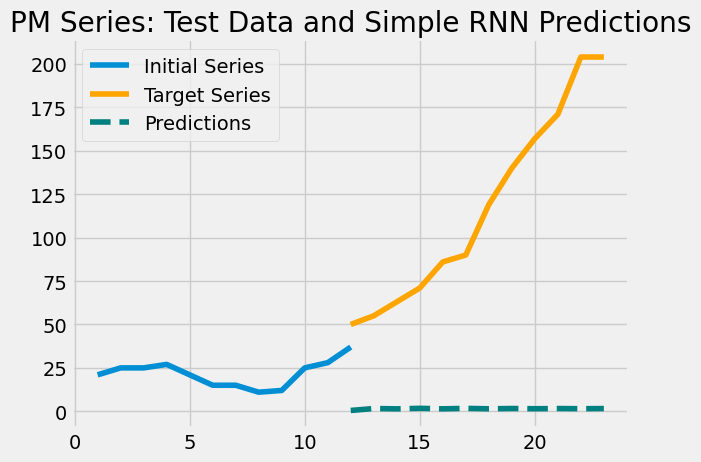

In [12]:
predict_and_plot(test_X_init, test_y, model,
                 'PM Series: Test Data and Simple RNN Predictions')

Retrain the model a few times in order to get results that we're happy with.

1/1 [==============================] - 0s 26ms/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 30)                960       
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 991 (3.87 KB)
Trainable params: 991 (3.87 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


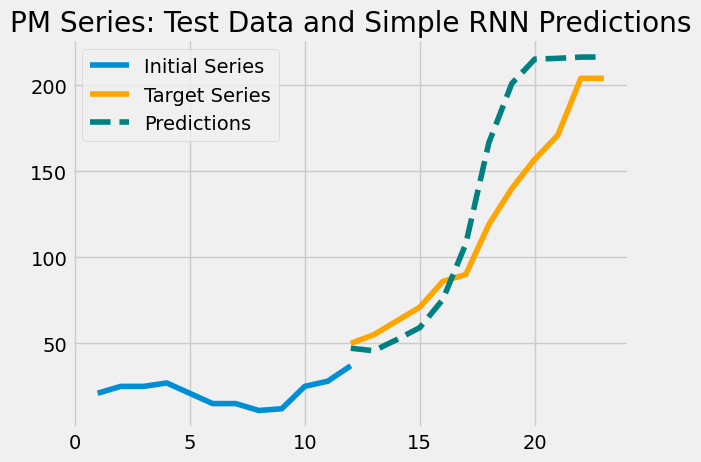

In [13]:
model = fit_SimpleRNN(train_X, train_y, cell_units=30, epochs=1200)
predict_and_plot(test_X_init, test_y, model,
                 'PM Series: Test Data and Simple RNN Predictions')

model.summary()

# LSTM

Write a new function for fitting an LSTM with keras

In [14]:
def fit_LSTM(train_X, train_y, cell_units, epochs):
    """
    Fit LSTM to data train_X, train_y

    arguments
    ---------
    train_X (array): input sequence samples for training
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for LSTM cells
    epochs (int): number of training epochs
    """

    # initialize model
    model = Sequential()

    # construct a LSTM layer with specified number of hidden units
    # per cell and desired sequence input format
    model.add(LSTM(cell_units, input_shape=(train_X.shape[1],1))) #,return_sequences= True))
    #model.add(LSTM(cell_units_l2, input_shape=(train_X.shape[1],1)))

    # add an output layer to make final predictions
    model.add(Dense(1))

    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs)
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=0)

    return model

Train a LSTM to forecast the PM_Nongzhanguan time series

In [15]:
df_Beijing['PM_Nongzhanguan'] = df_Beijing['PM_Nongzhanguan'].interpolate()

1/1 [==============================] - 0s 27ms/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 70)                20160     
                                                                 
 dense_2 (Dense)             (None, 1)                 71        
                                                                 
Total params: 20231 (79.03 KB)
Trainable params: 20231 (79.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


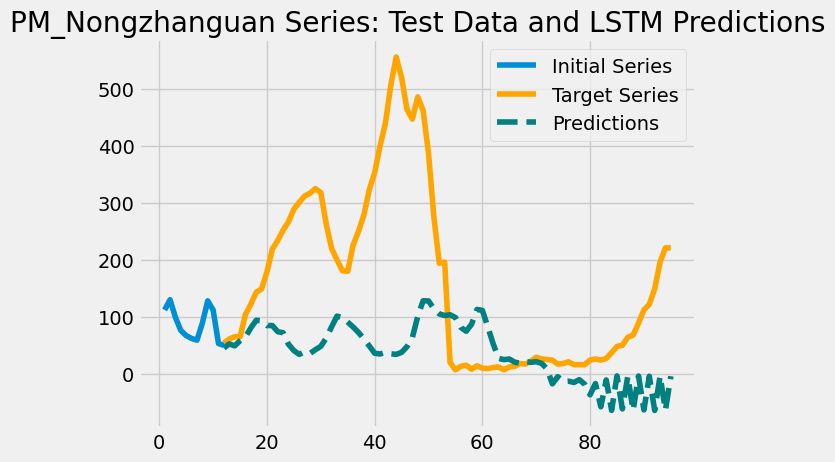

In [16]:
series_days = 50
input_hours = 12
test_hours = 96


train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df_Beijing, 'PM_Nongzhanguan', series_days,
                         input_hours, test_hours))

model = fit_LSTM(train_X, train_y, cell_units=70, epochs=3000)

predict_and_plot(test_X_init, test_y, model,
                 'PM_Nongzhanguan Series: Test Data and LSTM Predictions')

model.summary()

# Supplementary Activity



*   Train your own model to forecast the "PM_Nongzhanguan" series from the Beijing dataframe.
*   Train a LSTM to forecast the PM_Dongsi time series



*Train your own model to forecast the "PM_Nongzhanguan" series from the Beijing dataframe.*

In [17]:
%matplotlib inline
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM

In [18]:
df_Beijing = pd.read_csv('/content/drive/MyDrive/data sci 3 files/mounted files/Beijing.csv')
df_Beijing = df_Beijing[df_Beijing.year >= 2015]
df_Beijing.head(10)

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
43824,43825,2015,1,1,0,4,5.0,32.0,8.0,22.0,-21.0,29.0,1034.0,-6.0,SE,0.89,0.0,0.0
43825,43826,2015,1,1,1,4,4.0,12.0,7.0,9.0,-22.0,23.0,1034.0,-4.0,NW,4.92,0.0,0.0
43826,43827,2015,1,1,2,4,3.0,19.0,7.0,9.0,-21.0,27.0,1034.0,-5.0,NW,8.94,0.0,0.0
43827,43828,2015,1,1,3,4,4.0,9.0,11.0,13.0,-21.0,29.0,1035.0,-6.0,NW,12.96,0.0,0.0
43828,43829,2015,1,1,4,4,3.0,11.0,5.0,10.0,-21.0,27.0,1034.0,-5.0,NW,16.98,0.0,0.0
43829,43830,2015,1,1,5,4,3.0,18.0,3.0,6.0,-22.0,23.0,1034.0,-4.0,NW,24.13,0.0,0.0
43830,43831,2015,1,1,6,4,3.0,20.0,6.0,8.0,-23.0,22.0,1034.0,-5.0,NW,25.92,0.0,0.0
43831,43832,2015,1,1,7,4,3.0,22.0,7.0,17.0,-22.0,26.0,1035.0,-6.0,SE,1.79,0.0,0.0
43832,43833,2015,1,1,8,4,NaN,NaN,NaN,11.0,-22.0,29.0,1035.0,-7.0,cv,0.89,0.0,0.0
43833,43834,2015,1,1,9,4,5.0,37.0,11.0,33.0,-22.0,24.0,1035.0,-5.0,NE,1.79,0.0,0.0


In [19]:
df_Beijing['PM_Nongzhanguan'] = df_Beijing['PM_Nongzhanguan'].interpolate()
df_Beijing['PM_Nongzhanguan'].head(10)

43824     8.0
43825     7.0
43826     7.0
43827    11.0
43828     5.0
43829     3.0
43830     6.0
43831     7.0
43832     9.0
43833    11.0
Name: PM_Nongzhanguan, dtype: float64

In [20]:
def get_n_last_days(df, series_name, n_days):
  """
  Extract last n_days of an hourly time series
  """
  return df[series_name][-(24*n_days):]
def plot_n_last_days(df, series_name, n_days):
  """
  Plot last n_days of an hourly time series
  """
  plt.plot(get_n_last_days(df, series_name, n_days), 'k-')
  plt.title('{0} Air Quality Time Series - {1} days'
  .format(series_name, n_days))
  plt.xlabel('Recorded Hour')
  plt.ylabel('Reading')
  plt.grid(alpha=0.3)

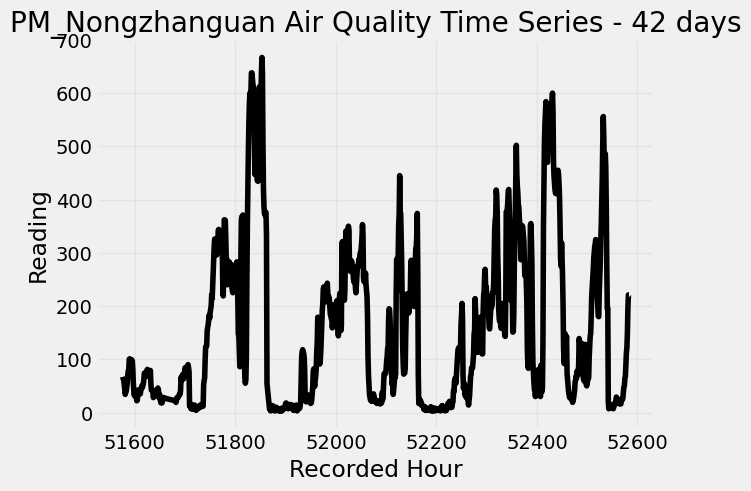

In [21]:
plot_n_last_days(df_Beijing, 'PM_Nongzhanguan', 42)

In [22]:
def get_keras_format_series(series):
    """
    Convert a series to a numpy array of shape
    [n_samples, time_steps, features]
    """

    series = np.array(series)
    return series.reshape(series.shape[0], series.shape[1], 1)

def get_train_test_data(df, series_name, series_days, input_hours,
                        test_hours, sample_gap=3):
    """
    Utility processing function that splits an hourly time series into
    train and test with keras-friendly format, according to user-specified
    choice of shape.

    arguments
    ---------
    df (dataframe): dataframe with time series columns
    series_name (string): column name in df
    series_days (int): total days to extract
    input_hours (int): length of sequence input to network
    test_hours (int): length of held-out terminal sequence
    sample_gap (int): step size between start of train sequences; default 5

    returns
    ---------
    tuple: train_X, test_X_init, train_y, test_y
    """

    forecast_series = get_n_last_days(df, series_name, series_days).values # reducing our forecast series to last n days

    train = forecast_series[:-test_hours] # training data is remaining days until amount of test_hours
    test = forecast_series[-test_hours:] # test data is the remaining test_hours

    train_X, train_y = [], []

    # range 0 through # of train samples - input_hours by sample_gap.
    # This is to create many samples with corresponding
    for i in range(0, train.shape[0]-input_hours, sample_gap):
        train_X.append(train[i:i+input_hours]) # each training sample is of length input hours
        train_y.append(train[i+input_hours]) # each y is just the next step after training sample

    train_X = get_keras_format_series(train_X) # format our new training set to keras format
    train_y = np.array(train_y) # make sure y is an array to work properly with keras

    # The set that we had held out for testing (must be same length as original train input)
    test_X_init = test[:input_hours]
    test_y = test[input_hours:] # test_y is remaining values from test set

    return train_X, test_X_init, train_y, test_y

In [23]:
series_days = 56
input_hours = 12
test_hours = 24

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df_Beijing, 'PM_Nongzhanguan', series_days,
                         input_hours, test_hours))

In [24]:
print('Training input shape: {}'.format(train_X.shape))
print('Training output shape: {}'.format(train_y.shape))
print('Test input shape: {}'.format(test_X_init.shape))
print('Test output shape: {}'.format(test_y.shape))

Training input shape: (436, 12, 1)
Training output shape: (436,)
Test input shape: (12,)
Test output shape: (12,)


In [25]:
def fit_SimpleRNN(train_X, train_y, cell_units, epochs):
    """
    Fit Simple RNN to data train_X, train_y

    arguments
    ---------
    train_X (array): input sequence samples for training
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for RNN cells
    epochs (int): number of training epochs
    """

    # initialize model
    model = Sequential()

    # construct an RNN layer with specified number of hidden units
    # per cell and desired sequence input format
    model.add(SimpleRNN(cell_units, input_shape=(train_X.shape[1],1)))

    # add an output layer to make final predictions
    model.add(Dense(1))

    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs)
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=0)

    return model

In [26]:
model = fit_SimpleRNN(train_X, train_y, cell_units=10, epochs=10)

In [27]:
def predict(X_init, n_steps, model):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series
    """

    X_init = X_init.copy().reshape(1,-1,1)
    preds = []

    # iteratively take current input sequence, generate next step pred,
    # and shift input sequence forward by a step (to end with latest pred).
    # collect preds as we go.
    for _ in range(n_steps):
        pred = model.predict(X_init)
        preds.append(pred)
        X_init[:,:-1,:] = X_init[:,1:,:] # replace first 11 values with 2nd through 12th
        X_init[:,-1,:] = pred # replace 12th value with prediction

    preds = np.array(preds).reshape(-1,1)

    return preds

def predict_and_plot(X_init, y, model, title):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series,
    and plots these predictions against the ground truth for those steps

    arguments
    ---------
    X_init (array): initial sequence, must match model's input shape
    y (array): true sequence values to predict, follow X_init
    model (keras.models.Sequential): trained neural network
    title (string): plot title
    """

    y_preds = predict(test_X_init, n_steps=len(y), model=model) # predict through length of y
    # Below ranges are to set x-axes
    start_range = range(1, test_X_init.shape[0]+1) #starting at one through to length of test_X_init to plot X_init
    predict_range = range(test_X_init.shape[0], test_hours)  #predict range is going to be from end of X_init to length of test_hours

    #using our ranges we plot X_init
    plt.plot(start_range, test_X_init)
    #and test and actual preds
    plt.plot(predict_range, test_y, color='orange')
    plt.plot(predict_range, y_preds, color='teal', linestyle='--')

    plt.title(title)
    plt.legend(['Initial Series','Target Series','Predictions'])

1/1 [==============================] - 0s 26ms/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 30)                960       
                                                                 
 dense_4 (Dense)             (None, 1)                 31        
                                                                 
Total params: 991 (3.87 KB)
Trainable params: 991 (3.87 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


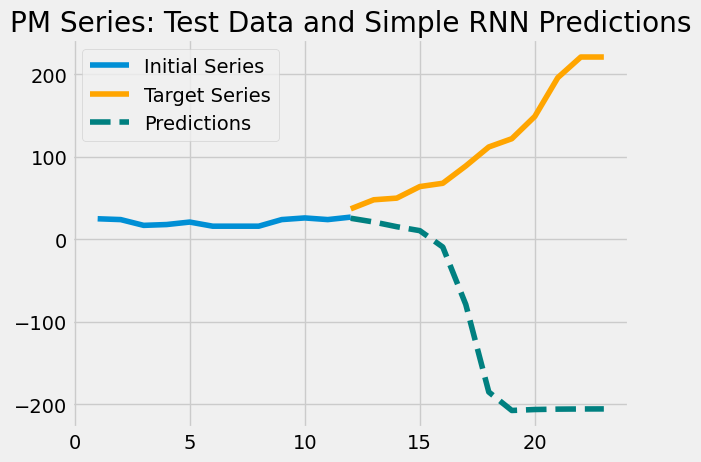

In [28]:
model = fit_SimpleRNN(train_X, train_y, cell_units=30, epochs=1200)
predict_and_plot(test_X_init, test_y, model,
                 'PM Series: Test Data and Simple RNN Predictions')

model.summary()

1/1 [==============================] - 0s 26ms/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 60)                3720      
                                                                 
 dense_5 (Dense)             (None, 1)                 61        
                                                                 
Total params: 3781 (14.77 KB)
Trainable params: 3781 (14.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


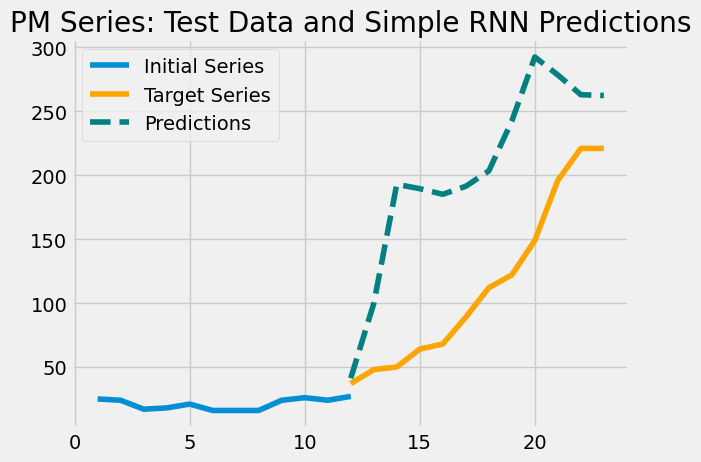

In [29]:
model = fit_SimpleRNN(train_X, train_y, cell_units=60, epochs=2000)
predict_and_plot(test_X_init, test_y, model,
                 'PM Series: Test Data and Simple RNN Predictions')

model.summary()

*Train a LSTM to forecast the PM_Dongsi time series*

In [30]:
def fit_LSTM(train_X, train_y, cell_units, epochs):
    """
    Fit LSTM to data train_X, train_y

    arguments
    ---------
    train_X (array): input sequence samples for training
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for LSTM cells
    epochs (int): number of training epochs
    """

    # initialize model
    model = Sequential()

    # construct a LSTM layer with specified number of hidden units
    # per cell and desired sequence input format
    model.add(LSTM(cell_units, input_shape=(train_X.shape[1],1))) #,return_sequences= True))
    #model.add(LSTM(cell_units_l2, input_shape=(train_X.shape[1],1)))

    # add an output layer to make final predictions
    model.add(Dense(1))

    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs)
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=0)

    return model

In [31]:
df_Beijing['PM_Dongsi'] = df_Beijing['PM_Dongsi'].interpolate()
df_Beijing['PM_Dongsi'].head(10)

43824    5.0
43825    4.0
43826    3.0
43827    4.0
43828    3.0
43829    3.0
43830    3.0
43831    3.0
43832    4.0
43833    5.0
Name: PM_Dongsi, dtype: float64

1/1 [==============================] - 0s 47ms/step
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 70)                20160     
                                                                 
 dense_6 (Dense)             (None, 1)                 71        
                                                                 
Total params: 20231 (79.03 KB)
Trainable params: 20231 (79.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


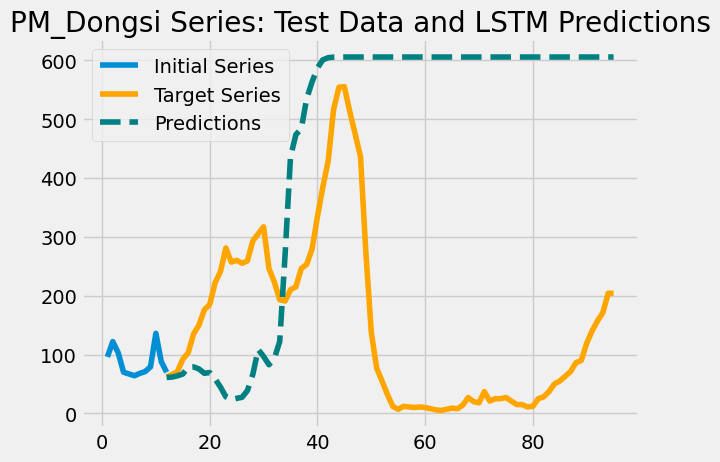

In [32]:
series_days = 50
input_hours = 12
test_hours = 96

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df_Beijing, 'PM_Dongsi', series_days,
                         input_hours, test_hours))

model = fit_LSTM(train_X, train_y, cell_units=70, epochs=3000)

predict_and_plot(test_X_init, test_y, model,
                 'PM_Dongsi Series: Test Data and LSTM Predictions')

model.summary()

1/1 [==============================] - 0s 25ms/step
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30)                3840      
                                                                 
 dense_7 (Dense)             (None, 1)                 31        
                                                                 
Total params: 3871 (15.12 KB)
Trainable params: 3871 (15.12 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


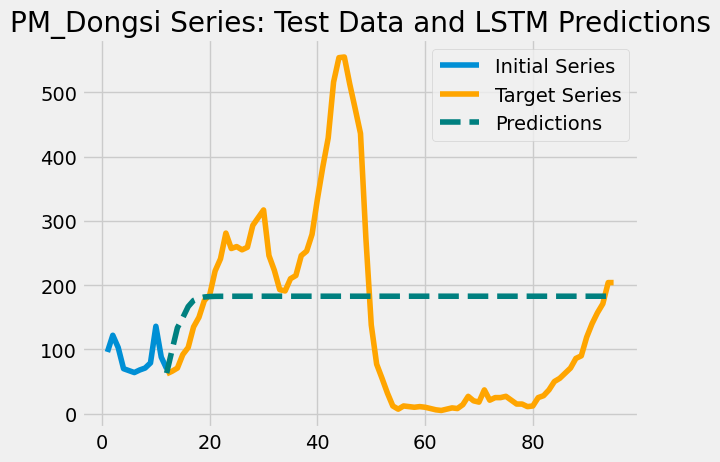

In [33]:
series_days = 50
input_hours = 12
test_hours = 96

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df_Beijing, 'PM_Dongsi', series_days,
                         input_hours, test_hours))

model = fit_LSTM(train_X, train_y, cell_units=30, epochs=1200)

predict_and_plot(test_X_init, test_y, model,
                 'PM_Dongsi Series: Test Data and LSTM Predictions')

model.summary()

# Conclusion

RNNs (Recurrent Neural Networks) process sequential data by maintaining a hidden state that captures information about previous time steps. While LSTMs (Long Short-Term Memory networks) is type of RNN designed to address the vanishing gradient problem. RNNs is for short-term dependencies and LSTMs are for long-term dependencies.

# Google Collab Link:

https://colab.research.google.com/drive/18u4ZlSS9VCGzQ2U9Kt6Iba70_J5Olypt?usp=sharing